In [1]:
import scipy.io as sio
import matplotlib.pyplot as plt
import numpy as np

s1 = sio.loadmat("sample_1.mat")
spike_times = s1["spike_times"][0][0][0]
spike_classes = s1["spike_class"][0][0][0]
print(np.unique(spike_classes))
print(spike_classes.shape)
print(spike_times.shape)
data = s1["data"][0]
print(data.shape)

[0 1 2]
(3214,)
(3214,)
(2880000,)


In [2]:
for key in s1.keys():
    print(f"{key}: {s1[key]}")

__header__: b'MATLAB 5.0 MAT-file, Platform: PCWIN, Created on: Fri May 29 09:02:26 2009'
__version__: 1.0
__globals__: []
samplingInterval: [[0.04166667]]
startData: [[0]]
chan: [[1]]
data: [[4.72638058 4.26466759 0.88346865 ... 6.72553154 5.56207971 3.00585866]]
spike_times: [[array([[    545,    1127,    2017, ..., 2877892, 2878542, 2879588]],
        dtype=int32)                                                  ]]
spike_class: [[array([[0, 0, 1, ..., 0, 0, 0]], dtype=uint8)]]


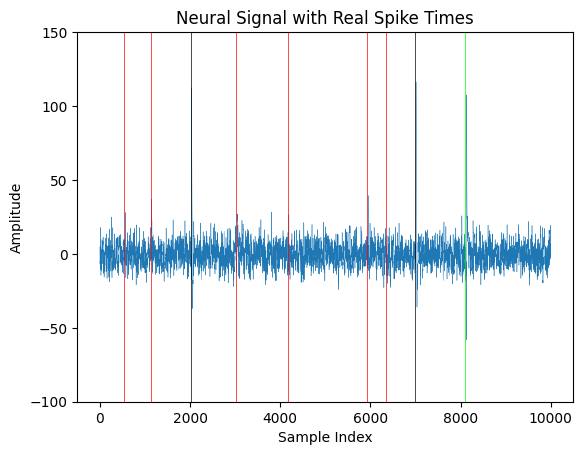

In [3]:
"""
Plot ground-truth spikes
"""
# Number of data points to plot
for a in range(1):
    plt.ylim(-100,150)
    plt.rcParams['figure.figsize'] = [20, 5]
    
    num_points_min = 10000*a
    num_points_max = 10000*(a+1)#data.shape[0]
    colors = ["red", "black", "lime"]

    # Plot
    plt.plot(np.linspace(start=num_points_min, stop=num_points_max,num=num_points_max-num_points_min), data[num_points_min:num_points_max], label='Neural Signal', zorder=1, linewidth=0.3)
    filter_condition = (spike_times < num_points_max) & (spike_times > num_points_min)
    zoomed = spike_times[filter_condition]
    #plt.scatter(zoomed, data[zoomed], color=[colors[i] for i in spike_classes[filter_condition]], label='Real Spike Times', zorder=2, s= 5)
    for i in range(zoomed.shape[0]):
        plt.axvline(zoomed[i], color=[colors[i] for i in spike_classes[filter_condition]][i], label='Real Spike Times', zorder=2, linewidth=.5)

    plt.title('Neural Signal with Real Spike Times')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    #plt.legend()

    plt.show()


In [4]:
sp = spike_times.copy()
sp.sort()

smallest_diff = (10000,-1)
for i in range(sp.shape[0]-1):
    diff = sp[i+1]-sp[i]
    if diff < smallest_diff[0]:
        smallest_diff = (diff,i,sp[i])
print(smallest_diff)


(np.int32(79), 2358, np.int32(2092756))


In [5]:
from scipy.signal import butter, filtfilt

def bandpass_filter(data, lowcut, highcut, fs, order=4):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist

    if not(0<low and 0<high and high<1):
        raise RuntimeError(f"bandpass_filter 0<{low} and 0<{high}<1")
    b, a = butter(order, [low, high], btype='band')
    y = filtfilt(b, a, data)
    return y

#data_filtered = bandpass_filter(data_normalized, 300, 3000, 24000)

In [6]:
def getSpiketimes(data, threshold, overlap_range):
    # if data is normalized, no need to adjust for variance. can just check threshold
    possible_spikes = np.array([i for i in range(data.shape[0]) if data[i]>=threshold])
    
    current = 0
    overlap_filtered = [possible_spikes[current]]
    for i in range(1, possible_spikes.shape[0]):
        if np.abs(possible_spikes[current] - possible_spikes[i]) <= overlap_range:
            continue
        current = i
        overlap_filtered.append(possible_spikes[i])
    return np.array(overlap_filtered)
#possible_spikes = getSpiketimes(data_filtered, 0.2)

In [7]:
def getSpikeRanges(data, possible_spikes, spike_before, spike_after):
    """extracts possible spiketimes from data
    1. filter for only points >= threshold
    2. filter out points, which are too close too another, because they are probably from the same spike
    3. extract the window around the spiketimes, i.e. [i-spike_before, i+spike_after] 

    may return inhomogenous arrays
    """
    
    spike_ranges = []
    for i in possible_spikes:
        before = i-spike_before 
        after = i+spike_after
        if i-spike_before < 0:
            before = 0
            spike_range = data[int(before):int(after)]
            # ensure all ranges are same length
            spike_range = np.pad(spike_range, (spike_before+spike_after-len(spike_range), 0), mode="constant", constant_values=0)
            spike_ranges.append(spike_range)
            continue
        elif i+spike_after >= data.shape[0]:
            after = i
            spike_range = data[int(before):int(after)]
            spike_range = np.pad(spike_range, (0, spike_before+spike_after-len(spike_range)), mode="constant", constant_values=0)
            spike_ranges.append(spike_range)
            continue
        spike_range = data[int(before):int(after)]
        spike_ranges.append(spike_range)
    return np.array(spike_ranges)

In [8]:
from scipy.signal import welch
from scipy.stats import kurtosis, skew, entropy

def getFeatures(spike_ranges):
    all_features = []

    for range in spike_ranges:
        range_features = []

        # data itself
        range_features = np.append(range_features, range)
        # highest amplitude
        range_features = np.append(range_features, np.max(range))
        # lowest amplitude
        range_features = np.append(range_features, np.min(range))
        # highest absolute amplitude
        #range_features = np.append(range_features, np.max(np.abs(range)))
        # peak to peak amplitude
        range_features = np.append(range_features, np.ptp(range))
        # dominant frequency
        #range_features = np.append(range_features, np.argmax(np.abs(np.fft.fft(range))))
        # Power Spectral Density (PSD)
        #range_features = np.append(range_features, welch(range,fs=24000, nperseg=10)[1])
        # Kurtosis
        #range_features = np.append(range_features, kurtosis(range))
        # Entropy
        #range_features = np.append(range_features, entropy(range))
        # Skewness
        #range_features = np.append(range_features, skew(range))
        # Slope
        #range_features = np.append(range_features, np.gradient(range))
        # Autokorrelation
        #range_features = np.append(range_features, np.correlate(range, range, mode='full')[-1])
        # signal energy
        #range_features = np.append(range_features, np.sum(range ** 2))
        # Root Mean Square
        #ange_features = np.append(range_features, np.sqrt(np.mean(range ** 2)))
        # Area under graph
        range_features = np.append(range_features, np.trapezoid(np.abs(range)))


        #range_features = np.array(range_features).reshape(1, -1).flatten()
        all_features.append(range_features)
    
    return np.array(all_features)

In [9]:
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

samplingRate = 24000
print("preprocessing")
data_processed = data
#data_processed = bandpass_filter(data_processed, lowcut=300, highcut=3000, fs=samplingRate)
data_processed = StandardScaler().fit_transform(data_processed.reshape(-1, 1)).flatten()


preprocessing


In [10]:
print("extract spike ranges")
possible_spikes = getSpiketimes(data_processed, threshold=3.434633422988655, overlap_range=75)
spike_ranges = getSpikeRanges(data_processed, possible_spikes, spike_before=50, spike_after=50)
print(possible_spikes)
print(np.shape(spike_ranges))

extract spike ranges
[   1146    2034    5950 ... 2870868 2877914 2879616]
(2013, 100)


In [11]:
def predictSpiketimes(data, threshold, overlap_range):
    data_processed = StandardScaler().fit_transform(data.reshape(-1, 1)).flatten()
    # threshold=3.434633422988655, overlap_range=75 work great
    possible_spikes = getSpiketimes(data_processed, threshold=threshold, overlap_range=overlap_range)
    return possible_spikes

In [12]:
print("extract features")
features = getFeatures(spike_ranges)
features = StandardScaler().fit_transform(features)
print(np.shape(features))

extract features
(2013, 104)


In [13]:
print("apply pca on features")
pca = PCA(n_components=2).fit(features)
pca_out = pca.transform(features)
print(pca_out.shape)
print(pca.explained_variance_ratio_)

apply pca on features
(2013, 2)
[0.24085136 0.1531751 ]


In [14]:
print("clustering")
n_clusters = 3
kmeans = KMeans(n_clusters=n_clusters).fit(pca_out)

cluster_labels = kmeans.labels_

clustering


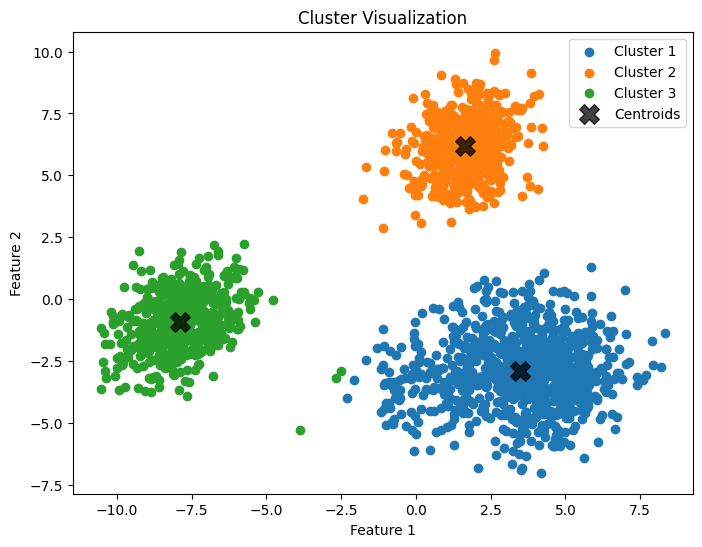

In [ ]:
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    cluster_points = pca_out[cluster_labels == i]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f'Cluster {i+1}')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.75, marker='X', label='Centroids')

plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Cluster Visualization')
plt.legend()
plt.show()

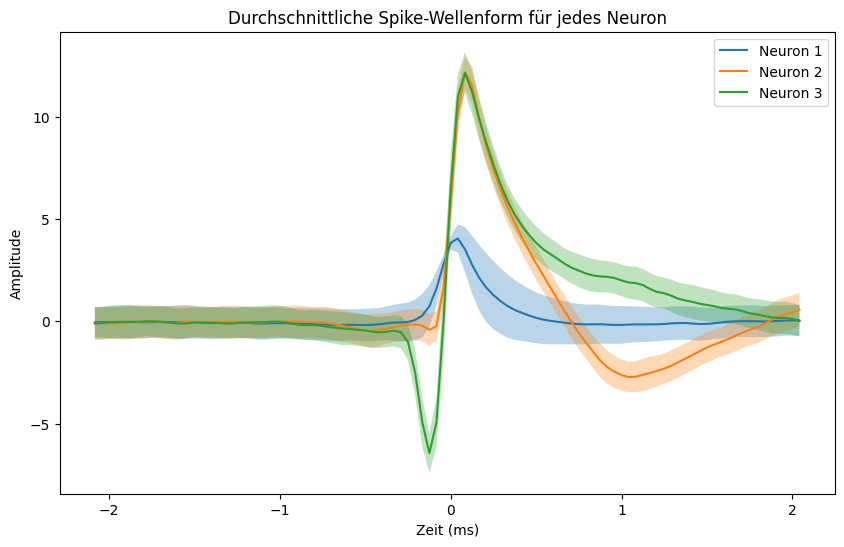

In [ ]:
num_clusters = len(np.unique(cluster_labels))
average_waveforms = []
std_waveforms = []
time_axis = np.arange(-50, 50) / samplingRate * 1000  # in ms, falls spike_before und spike_after = 50

for cluster_id in range(num_clusters):
    cluster_spikes = spike_ranges[cluster_labels == cluster_id]
    avg_waveform = cluster_spikes.mean(axis=0)
    std_waveform = cluster_spikes.std(axis=0)
    
    average_waveforms.append(avg_waveform)
    std_waveforms.append(std_waveform)

plt.figure(figsize=(10, 6))
for cluster_id in range(num_clusters):
    plt.plot(time_axis, average_waveforms[cluster_id], label=f'Neuron {cluster_id+1}')
    plt.fill_between(
        time_axis,
        average_waveforms[cluster_id] - std_waveforms[cluster_id],
        average_waveforms[cluster_id] + std_waveforms[cluster_id],
        alpha=0.3
    )

plt.title("Average Spike-Waveform for each neuron")
plt.xlabel("Zeit (ms)")
plt.ylabel("Amplitude")
plt.legend()
plt.show()

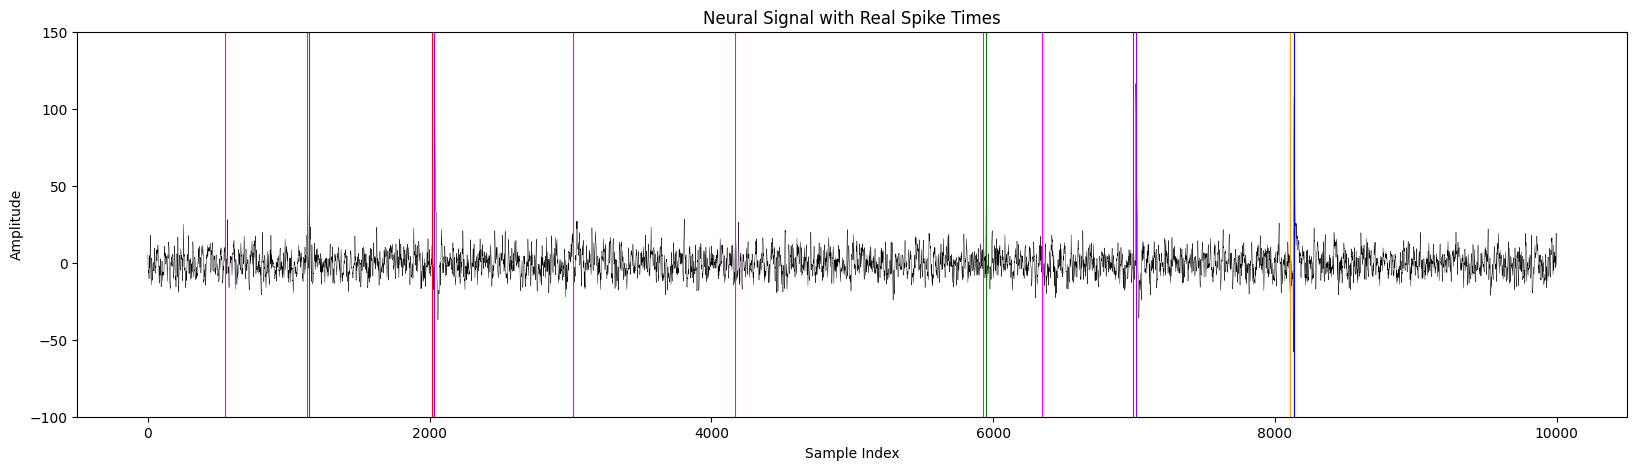

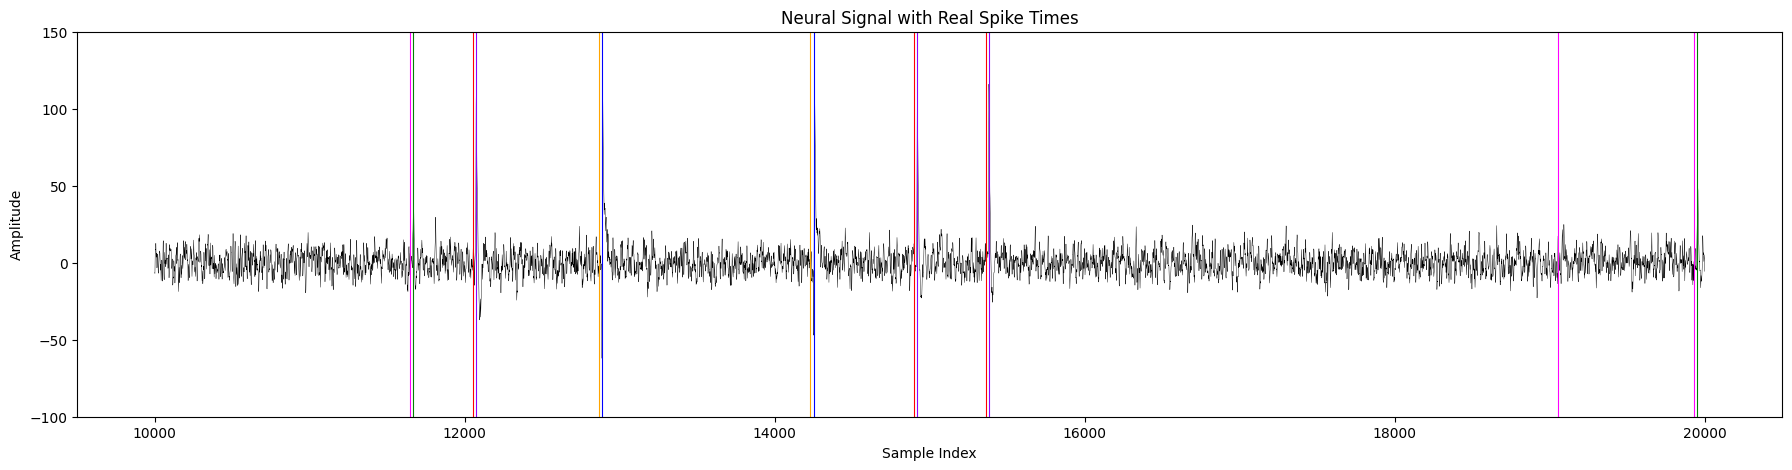

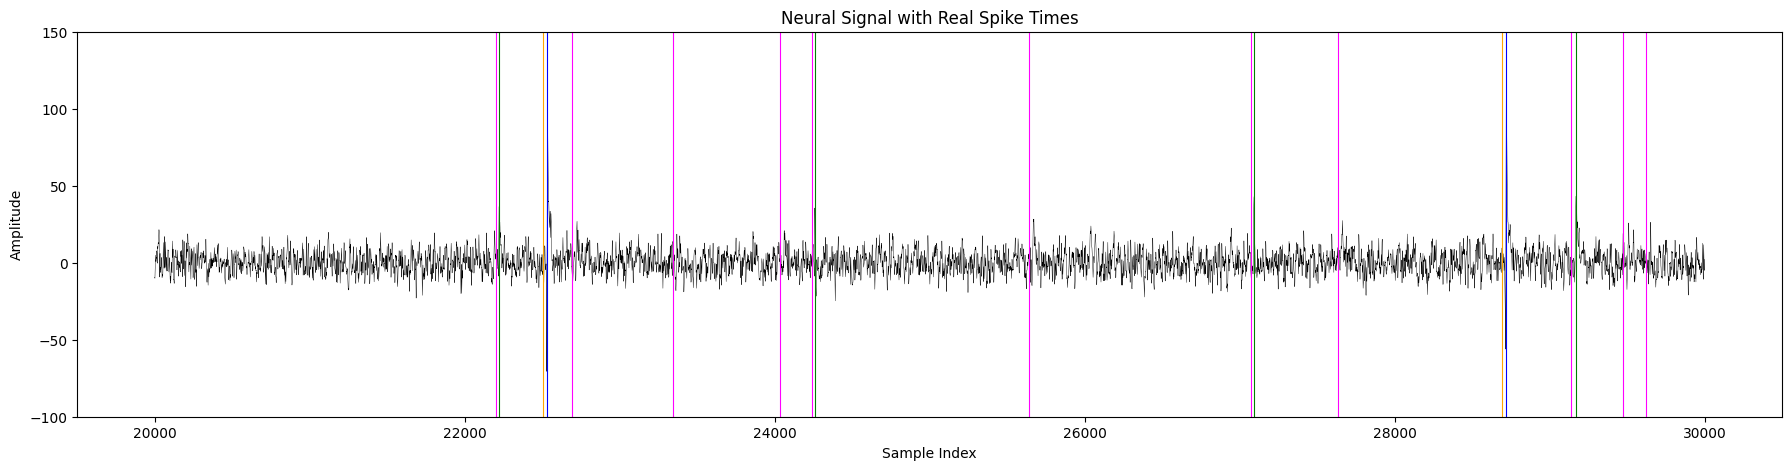

In [17]:
"""
Plot detected spikes
"""
# Number of data points to plot
for a in range(3):
    plt.ylim(-100,150)
    plt.rcParams['figure.figsize'] = [22, 5]
    
    num_points_min = 10000*a
    num_points_max = 10000*(a+1)#data.shape[0]
    cluster_colors = ["green", "#8f00ff", "blue", "black"] # 8f00ff=lila
    colors = ["magenta", "red", "orange", "gold"]

    # Plot
    plt.plot(np.linspace(start=num_points_min, stop=num_points_max,num=num_points_max-num_points_min), data[num_points_min:num_points_max], label='Neural Signal', 
             zorder=1, linewidth=0.3, color="black")
    #real
    filter_condition = (spike_times < num_points_max) & (spike_times > num_points_min)
    zoomed = spike_times[filter_condition]
    #plt.scatter(zoomed, data[zoomed], color=[colors[i] for i in spike_classes[filter_condition]], label='Real Spike Times', zorder=2, s= 5)
    for i in range(zoomed.shape[0]):
        plt.axvline(zoomed[i], color=[colors[i] for i in spike_classes[filter_condition]][i], label='Real Spike Times', zorder=2, linewidth=.8)
    #detected
    filter_condition = (possible_spikes < num_points_max) & (possible_spikes > num_points_min)
    zoomed = possible_spikes[filter_condition]
    #plt.scatter(zoomed, data[zoomed], color=[colors[i] for i in spike_classes[filter_condition]], label='Real Spike Times', zorder=2, s= 5)
    for i in range(zoomed.shape[0]):
        plt.axvline(zoomed[i], color=[cluster_colors[i] for i in cluster_labels[filter_condition]][i], label='Predicted Spike Times', zorder=2, linewidth=.8)

    plt.title('Neural Signal with Real Spike Times')
    plt.xlabel('Sample Index')
    plt.ylabel('Amplitude')
    #plt.legend()

    plt.show()


In [18]:
def countFP_FN_TP(realSpikes, predictedSpikes, tolerance=50):
    tp, fp, fn = 0, 0, 0
    i, j = 0, 0

    while i < len(predictedSpikes) and j < len(realSpikes):
        if abs(predictedSpikes[i] - realSpikes[j]) <= tolerance:
            tp += 1
            i += 1
            j += 1
        elif predictedSpikes[i] < realSpikes[j]:
            fp += 1
            i += 1
        else:
            fn += 1
            j += 1

    fp += len(predictedSpikes) - i
    fn += len(realSpikes) - j

    return fp, fn, tp


def calculate_f1_score(ground_truth, prediction, tolerance=30):
    # no sklearn f1 with tolerance

    # True Positives (TP):
    fp,fn,tp = countFP_FN_TP(ground_truth, prediction)
    #print(f"{tp} {fp} {fn}")

    # Precision and Recall
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0

    # F1-Score
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    return f1_score


print(calculate_f1_score(spike_times, possible_spikes))

0.7644920604553281


In [ ]:
import optuna
import numpy as np


def objective(trial):
    threshold_param = trial.suggest_float('threshold_params', 2.0, 5.0)
    overlap_param = trial.suggest_int('overlap_param', 0, 200)

    scores = []
    for name in ["sample_1.mat", "sample_2.mat", "sample_3.mat", "sample_4.mat", "sample_5.mat"]:
        data = sio.loadmat(name)["data"][0]
        spike_times = sio.loadmat(name)["spike_times"][0][0][0]
        detected_spikes = predictSpiketimes(data, threshold_param, overlap_param)
        s = calculate_f1_score(spike_times, detected_spikes, 30)
        scores.append(s)
    #print(scores)
    for s in scores:
        if s < 0.50:
            return 0

    return np.average(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print(f"best_params: {study.best_params}")
print(f"best_value: {study.best_value}")
# threshold=3.434633422988655, overlap_range=75 => ~0.777